In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, ResNet50_Weights, resnet50
import time
import matplotlib.pyplot as plt
import copy # For deep copying the model

In [42]:
# Replace the link with your ZIP file’s shared link
!gdown --fuzzy "https://drive.google.com/file/d/12UxU-N6tCAYKQsR9vVc3YxTtqQrDho4J/view?usp=drive_link"

# Unzip it
!unzip SIPAKMED_SPLIT-ZIP.zip -d /content/

!rm /content/SIPAKMED_SPLIT-ZIP.zip

Downloading...
From (original): https://drive.google.com/uc?id=12UxU-N6tCAYKQsR9vVc3YxTtqQrDho4J
From (redirected): https://drive.google.com/uc?id=12UxU-N6tCAYKQsR9vVc3YxTtqQrDho4J&confirm=t&uuid=75a27d6a-5202-41c3-83d9-7a5c6e74e9f1
To: /content/SIPAKMED_SPLIT-ZIP.zip
100% 676M/676M [00:03<00:00, 188MB/s]
Archive:  SIPAKMED_SPLIT-ZIP.zip
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/011.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/015.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/083.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/098.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/077.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/032.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/072.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/078.jpeg  
  inflating: /content/SIPAKMED_SPLIT/validation/Parabasal/071.jpeg  
  inflating: /content/SIPAKMED_SPLIT/va

In [47]:
# --- 1. Configuration ---
TRAIN_DIR_PATH = '/content/SIPAKMED_SPLIT/train'
VALIDATION_DIR_PATH = '/content/SIPAKMED_SPLIT/validation'
IMG_SIZE = (224, 224) # EfficientNet-B0 input size
BATCH_SIZE = 16
SEED = 123
NUM_CLASSES = 5 # Inferred from SIPAKMED dataset

# Training parameters
INITIAL_LR = 1e-3
INITIAL_EPOCHS = 20

FINE_TUNE_LR = 1e-5
FINE_TUNE_EPOCHS = 40 # Set to 40 as per our last TF script

# Set seed for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [48]:
# --- 2. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [59]:
# --- 3. Data Augmentation and Loading ---
# Get weights for normalization
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

# Augmentations for training
# This is a stronger set of augmentations to break the plateau
train_transform = T.Compose([
    T.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=30),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=preprocess.mean, std=preprocess.std), # Use normalization from the pre-trained model
    T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0), # PyTorch's Cutout
])

# Validation (no augmentation)
val_transform = T.Compose([
    T.Resize(IMG_SIZE[0]), # Resize to 224 (T.Resize expects an int for square)
    T.CenterCrop(IMG_SIZE), # Center crop to 224x224
    T.ToTensor(),
    T.Normalize(mean=preprocess.mean, std=preprocess.std), # Use normalization from the pre-trained model
])

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(VALIDATION_DIR_PATH, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print(f"Found {len(class_names)} classes: {class_names}")

Found 5 classes: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']


In [60]:
def build_model(num_classes):
    # Load pre-trained ResNet50
    model = resnet50(weights=weights)

    # Freeze all base model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the classifier
    in_features = model.fc.in_features

    # Replace the classifier (model.fc) with a new head
    model.fc = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(512, num_classes)
    )

    return model

model = build_model(NUM_CLASSES).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [61]:
# --- 5. Training Loop Function ---
def train_model(model, criterion, optimizer, scheduler, dataloader, dataset_size):
    model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    return epoch_loss, epoch_acc

In [62]:
# --- 6. Validation Loop Function ---
def validate_model(model, criterion, dataloader, dataset_size):
    model.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad(): # No gradients needed for validation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    return epoch_loss, epoch_acc

# Helper function to run the full training process
def run_training(model, criterion, optimizer, scheduler, num_epochs, is_cosine_scheduler=False):
    start_time = time.time()

    # Store history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Store the best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        train_loss, train_acc = train_model(model, criterion, optimizer, scheduler, train_loader, dataset_sizes['train'])

        # Validation phase
        val_loss, val_acc = validate_model(model, criterion, val_loader, dataset_sizes['val'])

        # Update LR scheduler
        if is_cosine_scheduler:
            scheduler.step() # Cosine scheduler steps every epoch
        else:
            scheduler.step(val_loss) # ReduceLROnPlateau steps on validation loss

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.8f}')

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item()) # .item() to get float from tensor
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [65]:
# --- 7. Phase 1: Initial Training (Feature Extraction) ---
print("--- Starting Phase 1: Feature Extraction ---")

# We only optimize the parameters of the new classifier
optimizer_initial = optim.Adam(model.fc.parameters(), lr=INITIAL_LR)
criterion = nn.CrossEntropyLoss()
scheduler_initial = ReduceLROnPlateau(optimizer_initial, 'min', factor=0.2, patience=3)

model, history_initial = run_training(model, criterion, optimizer_initial, scheduler_initial, INITIAL_EPOCHS)

--- Starting Phase 1: Feature Extraction ---
Epoch 1/20
----------
Train Loss: 1.1934 Acc: 0.5156
Val Loss: 0.8758 Acc: 0.6939
Current LR: 0.00100000

Epoch 2/20
----------
Train Loss: 0.7895 Acc: 0.7195
Val Loss: 0.6679 Acc: 0.7908
Current LR: 0.00100000

Epoch 3/20
----------
Train Loss: 0.7112 Acc: 0.7273
Val Loss: 0.6009 Acc: 0.8061
Current LR: 0.00100000

Epoch 4/20
----------
Train Loss: 0.5929 Acc: 0.7779
Val Loss: 0.5805 Acc: 0.8214
Current LR: 0.00100000

Epoch 5/20
----------
Train Loss: 0.5593 Acc: 0.8039
Val Loss: 0.5416 Acc: 0.8112
Current LR: 0.00100000

Epoch 6/20
----------
Train Loss: 0.5214 Acc: 0.7922
Val Loss: 0.5117 Acc: 0.8316
Current LR: 0.00100000

Epoch 7/20
----------
Train Loss: 0.5361 Acc: 0.8000
Val Loss: 0.5090 Acc: 0.8214
Current LR: 0.00100000

Epoch 8/20
----------
Train Loss: 0.5281 Acc: 0.8169
Val Loss: 0.4744 Acc: 0.8316
Current LR: 0.00100000

Epoch 9/20
----------
Train Loss: 0.5006 Acc: 0.8091
Val Loss: 0.4568 Acc: 0.8418
Current LR: 0.00100000

E

In [67]:
# --- 8. Phase 2: Fine-Tuning ---
print("\n--- Starting Phase 2: Fine-Tuning ---")

# Unfreeze the top blocks of the model
# ResNet50 layers are: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4
# We'll unfreeze from layer3 onwards (index 6)
child_layers = list(model.children())
for i, child in enumerate(child_layers):
    if i >= 6: # Unfreeze layer3 (idx 6) and layer4 (idx 7)
        for param in child.parameters():
            param.requires_grad = True

# We also need to train the classifier (model.fc)
for param in model.fc.parameters():
    param.requires_grad = True

# Create a new optimizer for all trainable parameters
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer_fine = optim.Adam(trainable_params, lr=FINE_TUNE_LR)

# Use CosineDecay (CosineAnnealingLR)
scheduler_fine = CosineAnnealingLR(optimizer_fine, T_max=FINE_TUNE_EPOCHS, eta_min=1e-7)

model, history_fine = run_training(model, criterion, optimizer_fine, scheduler_fine, FINE_TUNE_EPOCHS, is_cosine_scheduler=True)

# Save the final model
torch.save(model.state_dict(), 'sipakmed_ResNet50_pytorch.pth')
print("Model saved to sipakmed_ResNet50_pytorch.pth")


--- Starting Phase 2: Fine-Tuning ---
Epoch 1/40
----------
Train Loss: 0.4138 Acc: 0.8351
Val Loss: 0.4179 Acc: 0.8622
Current LR: 0.00000998

Epoch 2/40
----------
Train Loss: 0.3816 Acc: 0.8519
Val Loss: 0.4049 Acc: 0.8673
Current LR: 0.00000994

Epoch 3/40
----------
Train Loss: 0.3502 Acc: 0.8701
Val Loss: 0.4253 Acc: 0.8724
Current LR: 0.00000986

Epoch 4/40
----------
Train Loss: 0.3143 Acc: 0.8766
Val Loss: 0.3963 Acc: 0.8571
Current LR: 0.00000976

Epoch 5/40
----------
Train Loss: 0.3568 Acc: 0.8688
Val Loss: 0.3970 Acc: 0.8622
Current LR: 0.00000962

Epoch 6/40
----------
Train Loss: 0.3723 Acc: 0.8571
Val Loss: 0.3860 Acc: 0.8776
Current LR: 0.00000946

Epoch 7/40
----------
Train Loss: 0.3416 Acc: 0.8662
Val Loss: 0.3954 Acc: 0.8776
Current LR: 0.00000927

Epoch 8/40
----------
Train Loss: 0.3647 Acc: 0.8623
Val Loss: 0.3660 Acc: 0.8776
Current LR: 0.00000905

Epoch 9/40
----------
Train Loss: 0.3331 Acc: 0.8831
Val Loss: 0.3935 Acc: 0.8827
Current LR: 0.00000881

Epoch 1

Plotting training history...


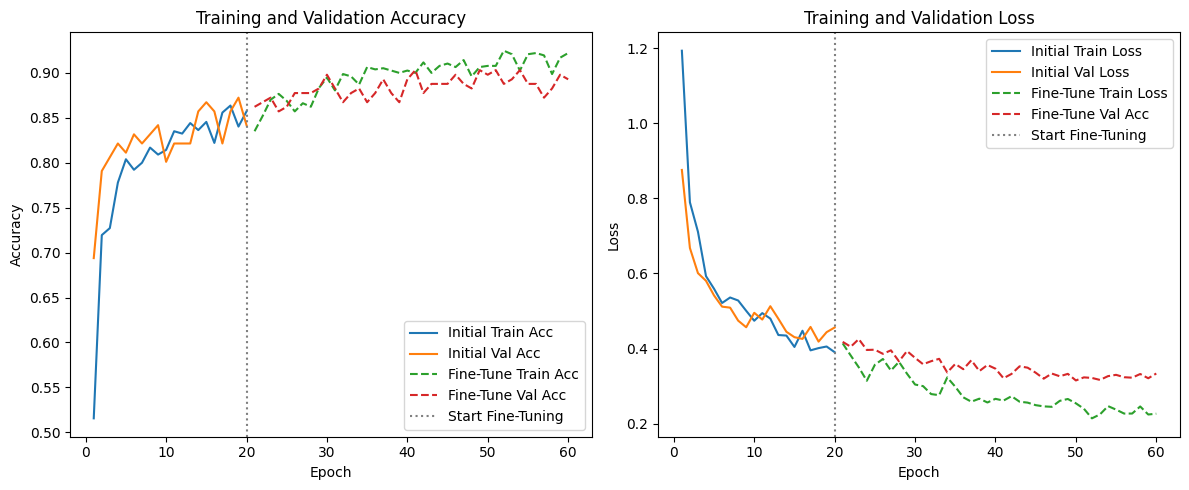

Script finished.


In [68]:
# --- 9. Plot Results ---
def plot_history(history_initial, history_fine):
    acc = history_initial['train_acc'] + history_fine['train_acc']
    val_acc = history_initial['val_acc'] + history_fine['val_acc']
    loss = history_initial['train_loss'] + history_fine['train_loss']
    val_loss = history_initial['val_loss'] + history_fine['val_loss']

    epochs_initial = range(1, len(history_initial['train_acc']) + 1)
    epochs_fine = range(len(history_initial['train_acc']) + 1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_initial, history_initial['train_acc'], label='Initial Train Acc')
    plt.plot(epochs_initial, history_initial['val_acc'], label='Initial Val Acc')
    plt.plot(epochs_fine, history_fine['train_acc'], label='Fine-Tune Train Acc', linestyle='--')
    plt.plot(epochs_fine, history_fine['val_acc'], label='Fine-Tune Val Acc', linestyle='--')
    plt.axvline(len(history_initial['train_acc']), color='grey', linestyle=':', label='Start Fine-Tuning')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_initial, history_initial['train_loss'], label='Initial Train Loss')
    plt.plot(epochs_initial, history_initial['val_loss'], label='Initial Val Loss')
    plt.plot(epochs_fine, history_fine['train_loss'], label='Fine-Tune Train Loss', linestyle='--')
    plt.plot(epochs_fine, history_fine['val_loss'], label='Fine-Tune Val Acc', linestyle='--')
    plt.axvline(len(history_initial['train_acc']), color='grey', linestyle=':', label='Start Fine-Tuning')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history_pytorch.png')
    plt.show()

print("Plotting training history...")
plot_history(history_initial, history_fine)

print("Script finished.")